# This notebook run code(s) on multiple animal/session/ for RAT Behavioral experiment

### This notebook is at the core of the pipeline of data processing. Do not play with it lightly inside the master folder (load_preprocess_rat)

#### 1. Only modifiy if you are sure of what you are doing and that you are solving a bug
#### 2. If you do modify you MUST commit this modification using bitbucket
#### 3. If you want to play whis notebook (to understand it better) copy it on a toy folder distinct from the master folder
#### 4. If you want to modify this code (fix bug, improve, add attributes ...) it is recommanded  to first duplicate in a draft folder. Try to keep track of your change.
#### 5. When you are ready to commit : # clear all output, clean everything between hashtag 



## 1. Load packages and define functions

In [ ]:
#modules to find path of all sessions
import glob
import os, logging
import gc
import numpy as np
from IPython.display import clear_output, display, HTML, Image
import matplotlib.cm as cm
from platform import system as OS
from multiprocessing import Pool
import threading
import warnings
warnings.filterwarnings("ignore")
import sys
import scipy.stats
#run other notebooks

# The lines below allow to run required notebook from the master folder
if "__file__" not in dir():
    
    ThisNoteBookPath=os.path.dirname(os.path.realpath("__file__"))
    CommonNoteBookesPath=os.path.join(os.path.split(ThisNoteBookPath)[0],"load_preprocess_rat")
    CWD=os.getcwd()
    os.chdir(CommonNoteBookesPath)
    %run UtilityTools.ipynb
    %run Animal_Tags.ipynb
    %run loadRat_documentation.ipynb
    %run plotRat_documentation_1_GeneralBehavior.ipynb
    %run plotRat_documentation_3_KinematicsInvestigation.ipynb
    os.chdir(CWD)

    # PARAMETERS (used if the pickles don't exist)
    param={
        "goalTime":7,#needed for pavel data only
        "treadmillRange":[0,90],#pavel error conversion "treadmillRange":[0,80]
        "maxTrialDuration":15,
        "interTrialDuration":10,#None pavel
        "endTrial_frontPos":30,
        "endTrial_backPos":55, 
        "endTrial_minTimeSec":4,
        "cameraSamplingRate":25, #needed for new setup    

        "sigmaSmoothPosition":0.1,#0.33, 0.18 pavel
        "sigmaSmoothSpeed":0.3,#0.3, 0.5 pavel
        "nbJumpMax":100,#200 pavel
        "binSize":0.25,
        #parameters used to preprocess (will override the default parameters)
    }  

    if OS()=='Linux':
        root="/data"
    elif OS()=='Windows':
        root="C:\\DATA\\"
    else:
        root="/Users/davidrobbe/Documents/Data/"
        
    logging.getLogger().setLevel(logging.INFO)

    print('os:',OS(),'\nroot:',root,'\nImport successful!')

In [ ]:
def compute_or_read_stats(data, PerfParamToPlot, 
                          saveAsPickle=True, pickleName="behaviorStats.p",redo=False):
    """
    Function to calculate the performance parameters of a single session
    """
    pathPickle=os.path.join(data.analysisPath,pickleName)
    if os.path.exists(pathPickle) and not redo:
        with open(pathPickle,"rb") as f:
            result=pickle.load(f)
            if set(PerfParamToPlot).issubset(set(result.keys())):
                result={key:result[key] for key in result.keys() if key in PerfParamToPlot}
                return result
            else:
                params=list(set(PerfParamToPlot).difference(set(result.keys())))
                result={key:result[key] for key in result.keys() if key not in params}
            f.close()
    else:
        params=PerfParamToPlot
        result={}
    for param in params:
        try:
            if param=="% good trials":
                #percentage of good trials
                result[param]=np.round(len(data.goodTrials)/(float(data.nTrial)+0) *100)
            elif param=="% good trials on last 40":
                #percentage of good trials in the 40 last trials
                last40GoodTrial=[trial for trial in data.goodTrials if trial>(data.nTrial-41)]
                result[param]=np.round(len(last40GoodTrial)/40.0 *100)
            elif param=="percentile entrance time":
                #percentile entrance time
                realEntranceTimes=data.entranceTime[data.entranceTime<data.maxTrialDuration]
                if len(realEntranceTimes)>0:
                    entranceTimeP=np.nanpercentile(realEntranceTimes,[10,25,50,75,90])
                    result[param]=entranceTimeP
                else:
                    result[param]=np.full(5,data.maxTrialDuration[0])
            elif param=="median entrance time (sec)":
                #median and std of entrance time
                result[param]=np.nanmedian(data.entranceTime[data.entranceTime<data.maxTrialDuration])
            elif param=="standard deviation of entrance time":    
                result[param]=np.nanstd(data.entranceTime)
            elif param=="mean entrance time (sec)":
                result[param]=np.nanmean(data.entranceTime[data.entranceTime<data.maxTrialDuration])

                #median correlation trajectories
                #result["median correlation of trajectories"]=plot_correlation_position(data,onlyGood=True)
            elif param=="spearman entrance time":
                #correlation entrance time
                result[param]=plot_correlation_entrance_time(data)
            elif param=="time running forward":
                #proportion of time running forward
                areaUnderCurve=plot_proportionTimeRunningForward_TrajEnd(data,binSize=1,minSpeed=-20,maxSpeed=120,smoothSpeed=0.3,onlyGood=False,highSpeed=None)
                result[param]=areaUnderCurve
            elif param=="timerunningforwardGoodTrials":
                #proportion of time running forward for good trials
                areaUnderCurve=plot_proportionTimeRunningForward_TrajEnd(data,binSize=1,minSpeed=-20,maxSpeed=120,smoothSpeed=0.3,onlyGood=True,highSpeed=None)
                result[param]=areaUnderCurve
            elif param=="Forward Speed":
                #Forward Speed
                result[param]=plot_mean_forwardSpeed(data,smoothSpeed=0.3,onlyGood=False)
                plt.close()
            elif param=="Forward Speed Vs TreadmillSpeed":
                #Forward Speed vs TreadmillSpeed
                result[param]=plot_mean_forwardSpeedVsTreadmillSpeed(data,smoothSpeed=0.3,onlyGood=False)
                plt.close()
            elif param=="Forward Speed good trials":
                #Forward Speed for good trials
                result[param]=plot_mean_forwardSpeed(data,smoothSpeed=0.3,onlyGood=True)
                plt.close()
            elif param=="Tortuosity":
                #Tortuosity  and StraightSpeedForward
                SessionTortuosity,SessionStraightSpeed=plot_Tortuosity(data, onlyGood=False)
                plt.close()
                result[param]=SessionTortuosity
            elif param=="Straight Speed Forward":
                SessionTortuosity,SessionStraightSpeed=plot_Tortuosity(data, onlyGood=False)
                plt.close()
                result[param]=SessionStraightSpeed
            elif param=="Trajectory Correlation":
                #Trajectory Correlation
                SessionCorrelationTrajectory= plot_correlation_position(data,onlyGood=False,raw=False)
                plt.close()
                result[param]=SessionCorrelationTrajectory
            elif param=="Trajectory Correlation good trials":
                #Trajectory Correlation for good trials
                SessionCorrelationTrajectory= plot_correlation_position(data,onlyGood=True,raw=False)
                plt.close()
                result[param]=SessionCorrelationTrajectory
            elif param=="Std from goaltime":
                #Std from goaltime
                result[param]=std_from_goaltime(data)
            elif param=="Delivered Reward Ratio":
                result[param]=data.deliveredRewardRatio
            elif param=="Number of missed trials":
                result[param]=sum(data.entranceTime<0.1)+sum(data.entranceTime>data.maxTrialDuration-1)
            elif param=="Mean Pairwise RMSE":
                m,_=plot_rmse(data,alignedOnBegining=True,onlyGood=False,raw=False)
                result[param]=m
            elif param=="Entropy":
                _,H=plot_trajectory_PDF(data,TimeRes=.5,PosRes=5,onlyGood=False)
                plt.close()
                result[param]=H
            elif param=="Run Distance":
                dis=plot_run_distance(data,onlyGood=False,raw=False)
                plt.close()
                result[param]=np.mean(dis)
            elif param=="Forward Running Speed":
                result[param]=np.mean(plot_forward_running_speed(data,minXBack=55,onlyGood=False))
                plt.close()
            elif param=="Lick Onset Delay":
                lickTrdStop=plot_lick_raster(data,plot_inset=False)
                plt.close()
                posLicks=[np.array(lick)[np.array(lick)>0] for i,lick in enumerate(lickTrdStop)
                          if len(lick)>0 and i in data.goodTrials]
                firstLick=[i[0] for i in posLicks if len(i)>0]
                result[param]=np.mean(firstLick)
            elif param=="Entrance Time MSE":
                result[param]=np.sum((data.entranceTime-data.goalTime.mean())**2)/len(data.entranceTime)
        except Exception as e:
            print(repr(e))
            result[param]=np.nan
    
    if saveAsPickle:
        with open(pathPickle, 'wb') as f:
            pickle.dump(result, f)
            f.close()
    
    return result

In [ ]:
def plot_learningCurves(root,animal,PerfParamToPlot,profile,
                        stop_date='',parameter={},
                        redoPreprocess=False, redoStat=False,override=False,plot=True,PrintWarning=False):
    results={}
    days=[]
    indexSession=[]
    events=[]
    errorSession=[]
    if animal=='':
        sessionProfile=batch_get_session_list(root,animalList=[],profile=profile,until_date=stop_date)
        if sessionProfile=={}:
            print('bad settings!')
            return False
        sessionList=sessionProfile['Sessions']
        animal=sessionList[0][:6]   #needs revision when needed!
    else:
        AnimalTagPath=os.path.join(root,animal,animal+'.tag')
        if not os.path.isfile(AnimalTagPath):
            print('No tag file for ',animal)
            return False

        #Get the list of good! sessions
        sessionProfile=get_session_list(AnimalTagPath,profile=profile,until_date=stop_date)
        sessionList=sessionProfile['Sessions']
        if sessionList==[] or sessionProfile=={}:
            print(animal,': Bad Tag file!')
            return False
    res_TS =[]
    #loop through sessions
    for session in sessionList:
        try:
            sessionData=Data(root,animal,session,parameter,redoPreprocess=redoPreprocess)
        except Exception as e:
            if PrintWarning:
                display(HTML("<b> An error happened, skip session. Error message: </b>"))
                display(HTML("<b>"+e.__class__.__name__+": "+str(e)+"</b>"))
                print("--------")
            
            errorSession.append(session)
            continue
        
        #---skip if file "NotToAnalyze"
        try:
            if "NotToAnalyze" in sessionData.emptyAnalysisFiles:
                if PrintWarning:
                    print("Not to analyze, skipped")
                    print("--------")
                continue 
        except:
            continue
           
        try :
            et=sessionData.entranceTime 
        except:
            if PrintWarning:
                print('No entrance time, skipped')
                print("--------")
            continue   
        #skip if training data or no break time
        if (not sessionData.hasBehavior):
            if PrintWarning:
                print("No Behavior, skipped")
                print("--------")
            continue
        
        #plot the png image in session folder
        sessionData.plot_session_png_html([plot_session_behavior],override=override)

        days.append(sessionData.daySinceStart)
        events.append(sessionProfile['Event'][sessionList.index(session)])
        events[-1]=events[-1] if len(events[-1]) >=3 else ''
        eventDay=[days[i] for i,_ in enumerate(events) if events[i] != '']
            
        #Compute a bunch of Performance Parameters using a dedicated function
        res=compute_or_read_stats(sessionData,PerfParamToPlot,redo=redoStat)
        #--------------------session parameters---------------
        #treadmill speed
        uniqueTreadSpeed=np.unique(sessionData.treadmillSpeed)
        if len(uniqueTreadSpeed)<len(sessionData.treadmillSpeed)*0.8:
            res["treadmillSpeed"]=scipy.stats.mode(sessionData.treadmillSpeed,nan_policy='omit')[0][0]
        else:
            res["treadmillSpeed"]='var '
        #goaltime. In some rare cases goaltime is NaN, as entrenace time was not written properly during data acquisition
        res["goalTime"]=np.unique(sessionData.goalTime[~np.isnan(sessionData.goalTime)])
        if len(res["goalTime"])>1:
            res["goalTime"]=np.median(res["goalTime"])
        
        res["maxTrialDuration"]=float(np.nanmax(sessionData.maxTrialDuration))
               
        keys = list(res.keys())
        for key in keys:
            try:
                results[key].append(res[key])
            except KeyError:
                results[key]=[res[key]]
    
    # One subplot for every key in results
    nbCol=2
    nbLine=len(PerfParamToPlot)//nbCol+len(PerfParamToPlot)%nbCol
    if plot:    
        fig=plt.figure(figsize=(15, 3*nbLine))
        #fig.subplots_adjust(hspace=1)
        for index,key in enumerate(PerfParamToPlot):
            ax=plt.subplot(nbLine,nbCol,index+1)
            if key=="percentile entrance time":
                med=[array[2] for array in results[key]]
                lowestdist=[array[1] for array in results[key]]
                higestdist=[array[-2] for array in results[key]]
                lowError=[array[2]-array[1] for array in results[key]]
                highError=[array[3]-array[2] for array in results[key]]
                ax.errorbar(days,med,yerr=np.vstack([lowError,highError]),ls="",color='k')
                ax.scatter(days,med,c='k',zorder=10, s=20)
                ax.plot(days,med,color="lightgrey",linewidth=2)
                #ymax=max(higestdist)
                #ymin=min(lowestdist)
                key+=" (25% - 50% - 75%)"
                try:
                    ax.set_ylim([0,max(results['maxTrialDuration'])])
                except:
                    ax.set_ylim([0,15])
                
                ax.plot(days,results["goalTime"],color="red",linestyle='--')
            else:
                ax.plot(days,results[key],color="lightgrey",linewidth=2)
                ax.scatter(days,results[key],c='k',zorder=10,s=20)
                #ymax=max([x for x in results[key] if not isNone(x)])
                #ymin=min([x for x in results[key] if not isNone(x)])
           
            for day in eventDay:
                ax.axvline(day,color='m',linestyle='--')

            ax.set_title(animal+" "+key)
            ax.set_xlabel("session day")
            ax.xaxis.grid(which='major')  
            
#             if key=="median entrance time (sec)":
#                 ax.set_ylim([0,15])
#             if key=="treadmillSpeed":
#                 ax.set_ylim([0,35])
#             if key=="Trajectory Correlation":
#                 ax.set_ylim([0,1])
#             if key=="% good trials on last 40":
#                 ax.set_ylim([0,100])   
#                 plt.axhline(72.5,linestyle='--',color='red')
#             if key=="Forward Speed Vs TreadmillSpeed":
#                 ax.set_ylim([1,10])
#             if key=="Std from goaltime":
#                 ax.set_ylim([0,5])
#             if key=="Tortuosity":
#                 ax.set_ylim([0,10])

            major_ticks = np.arange(0, days[-1], 10)                                              
            minor_ticks = np.arange(0, days[-1], 2)                                               
            ax.set_xticks(major_ticks)                                                       
            #ax.set_xticks(minor_ticks, minor=True)
            ax.set_xlim([days[0]-1,days[-1]+1])
                 
        plt.tight_layout()            
        plt.subplots_adjust(top=0.9)
        #plot title
        speed=sessionProfile['Speed'][sessionProfile['Type'].index('Good')]
        tag  =sessionProfile['Tag'][sessionProfile['Type'].index('Good')]
        Title=animal+': '+tag+'@'+str(speed)
        for i,day in enumerate(eventDay):
            speed=str(sessionProfile['Speed'][days.index(day)])
            tag=sessionProfile['Tag'][days.index(day)]
            Title+=' > '+tag+'@'+speed
            if len(eventDay)>=5 and i%4==0:
                Title+='\n'
        plt.suptitle(Title)

        #save plot
        animalAnalysisPath=os.path.join(root,animal,"Analysis")
        fullPathLearningCurves=os.path.join(animalAnalysisPath,"LearningCurves.png")
        LearningCurveName=os.path.basename(fullPathLearningCurves)
        if not os.path.exists(animalAnalysisPath):
            os.mkdir(animalAnalysisPath)
        plt.savefig(fullPathLearningCurves)
        
        #Insert the learning curves png figure in the general HTML page that shows behavioral performance session by session(all_behavior_plot.html)        
        nameGeneralHTML = "all_plot_session_behavior.html"
        pathGeneralHTML = os.path.join(animalAnalysisPath, nameGeneralHTML)
        LearningCurveImage= ["<a href=#%s><center><img src='%s' alt='%s' title='LearningAcrossSession'/></center></a>"%(animalAnalysisPath, LearningCurveName,fullPathLearningCurves)]#Line to add
        sessionData.remove_lines_in_html(pathGeneralHTML, LearningCurveName) #remove the old LearningAcrossSession.png if there is one...
        sessionData.insert_in_html(pathGeneralHTML, LearningCurveImage, nameGeneralHTML) #insert the new one at the end
        
    results["days"]=days
    results.update({'sessionProfile':sessionProfile})

    #save learning curve of all performance and task param in pickle
    #saving happens ONLY if profile is empty (includes all the sessions)
    if profile=={} or list(profile.keys())==['Type']:
        results["days"]=days
        results.update({'sessionProfile':sessionProfile})

        path=os.path.join(root,animal,"Analysis")
        if not os.path.exists(path):
                os.mkdir(path)
        path=os.path.join(path,"learningStats.p")

        with open(path, 'wb') as f:
            pickle.dump(results, f)
            f.close()
        if PrintWarning:
            print("Save pickle: %s"%path)

    if errorSession:
        if PrintWarning:
            display(HTML("<b> An error happened for the following session(s):"))
            print("\n".join(errorSession))
    
    
    return results

## 2. Define animalList, the function(s) you want to run in batch and redo(s)

In [7]:
if "__file__" not in dir():
    
    #Define desired profile dictionary
    AnimalProfile={'Type':'Good',
         'rewardType':'Progressive',
         'initialSpeed':['10'],
         'Speed':'10',
         'Tag':'Control'
                  }

    animalList=batch_get_animal_list(root,AnimalProfile)
    print('animal list:',animalList)

animal list: ['Rat077', 'Rat078', 'Rat084', 'Rat085', 'Rat088', 'Rat091', 'Rat095', 'Rat096', 'Rat098', 'Rat103', 'Rat104', 'Rat110', 'Rat113', 'Rat120', 'Rat137', 'Rat138', 'Rat139', 'Rat140', 'Rat149', 'Rat150', 'Rat151', 'Rat152', 'Rat161', 'Rat162', 'Rat163', 'Rat164', 'Rat165', 'Rat166', 'Rat215', 'Rat216', 'Rat217', 'Rat218', 'Rat219', 'Rat220', 'Rat221', 'Rat222', 'Rat223', 'Rat224', 'Rat225', 'Rat226', 'Rat227', 'Rat228', 'Rat229', 'Rat230', 'Rat231', 'Rat232', 'Rat246', 'Rat247', 'Rat248', 'Rat249', 'Rat250', 'Rat251', 'Rat252', 'Rat253', 'Rat254', 'Rat255', 'Rat256', 'Rat257', 'Rat258', 'Rat259', 'Rat260', 'Rat261', 'Rat262', 'Rat263', 'Rat264', 'Rat265', 'Rat297', 'Rat298', 'Rat299', 'Rat300', 'Rat305', 'Rat306', 'Rat307', 'Rat308']


In [10]:
if "__file__" not in dir():

    res1=[]
    res2=[]
    for animal in animalList:
        res1.append(plot_learningCurves(root,animal=animal,PerfParamToPlot=["Forward Running Speed"],profile=AnimalProfile,
                             stop_date='',redoPreprocess=False,
                             redoStat=False,override=False,plot=False,PrintWarning=False)["Forward Running Speed"][-5:])
        res2.append(plot_learningCurves(root,animal=animal,PerfParamToPlot=['standard deviation of entrance time'],profile=AnimalProfile,
                         stop_date='',redoPreprocess=False,
                         redoStat=False,override=False,plot=False,PrintWarning=False)['standard deviation of entrance time'][-5:])

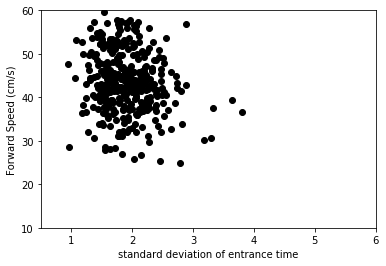

In [25]:
if "__file__" not in dir():

    ax=plt.figure().add_subplot(111)
    for i,animal in enumerate(animalList):
        ax.scatter(res2[i],res1[i],c='k')
    ax.set_xlabel("standard deviation of entrance time")
    ax.set_ylabel("Forward Speed (cm/s)")
    ax.set_xlim([.5,6])
    ax.set_ylim([10,60])

In [ ]:
if "__file__" not in dir():

    animalList=get_current_animals(days_passed=5)
#     animalList= ['Rat280', 'Rat281', 'Rat282', 'Rat283', 'Rat284', 'Rat285', 'Rat286', 'Rat291']
    animalList=['Rat280','Rat281','Rat282','Rat283','Rat284','Rat285','Rat286','Rat291','Rat301','Rat302','Rat303','Rat304']
    #     animalList.append("Rat132")
    print(len(animalList),'animals:\n',animalList)

In [8]:
if "__file__" not in dir():
    updateTagFiles = True   #update the outdated tag files, if needed (manual manipulation might be needed!)
    redoPreprocess = False  #redo basic preprocess and generate Data. Otherwise load from pickle 
    redoStat = False         #regenerate performance measures
    replaceHtml=False       #regenerate general HTML per animal. Otherwise use existing
    override = False        #regenerate single session png figure. Otherwise use existing
    plot=True
    PrintWarning=False
    PerfParamToPlot =["percentile entrance time",'standard deviation of entrance time',"% good trials on last 40",
                      "Trajectory Correlation","% good trials","Mean Pairwise RMSE","Forward Speed Vs TreadmillSpeed","Tortuosity","Run Distance","Delivered Reward Ratio","median entrance time (sec)"]
    PerfParamToPlot =["median entrance time (sec)","percentile entrance time","% good trials",'standard deviation of entrance time',"% good trials on last 40",
                      "Trajectory Correlation","Mean Pairwise RMSE","Forward Speed Vs TreadmillSpeed","Tortuosity","Run Distance"
                      ,"Delivered Reward Ratio","mean entrance time (sec)"]

#     PerfParamToPlot =["Forward Running Speed"]
    
    #put the desired profile for the sessions to be included
#     profile={'Type':'Good',
#          'rewardType':'Progressive',
#          'initialSpeed':'10',
#          'Speed':'10',
#          'Tag':'Control'
#          }
    profile={'Type':'Good'}#AnimalProfile
    # this is where you define a list of functions you want to run on your data (usually, don't touch!)
    plotFunctionList=[plot_session_behavior]

    #================================================
    print("animals that will be analyzed: %s"%animalList)

animals that will be analyzed: ['Rat077', 'Rat078', 'Rat084', 'Rat085', 'Rat088', 'Rat091', 'Rat095', 'Rat096', 'Rat098', 'Rat103', 'Rat104', 'Rat110', 'Rat113', 'Rat120', 'Rat137', 'Rat138', 'Rat139', 'Rat140', 'Rat149', 'Rat150', 'Rat151', 'Rat152', 'Rat161', 'Rat162', 'Rat163', 'Rat164', 'Rat165', 'Rat166', 'Rat215', 'Rat216', 'Rat217', 'Rat218', 'Rat219', 'Rat220', 'Rat221', 'Rat222', 'Rat223', 'Rat224', 'Rat225', 'Rat226', 'Rat227', 'Rat228', 'Rat229', 'Rat230', 'Rat231', 'Rat232', 'Rat246', 'Rat247', 'Rat248', 'Rat249', 'Rat250', 'Rat251', 'Rat252', 'Rat253', 'Rat254', 'Rat255', 'Rat256', 'Rat257', 'Rat258', 'Rat259', 'Rat260', 'Rat261', 'Rat262', 'Rat263', 'Rat264', 'Rat265', 'Rat297', 'Rat298', 'Rat299', 'Rat300', 'Rat305', 'Rat306', 'Rat307', 'Rat308']


## 3 - Loops through animals and session and functions (SLOW)

In [ ]:
if "__file__" not in dir():
    #---------------------------iterate over animal-------------------------------------
#     OUT={}
    for animal in animalList:
        print("Animal: %s"%animal)
        print("**********")
        if updateTagFiles:
            try:
                update_tag_file(root,animal)
            except:
                pass
            
        if replaceHtml:
            for plotFunction in plotFunctionList:
                name = str(plotFunction.__name__)
                #html for the animal
                generalName = "all_" + name
                AnalysisFolder = os.path.join(root, animal, "Analysis")
                generalPath = os.path.join(AnalysisFolder, generalName+".html")
                if os.path.exists(generalPath):
                    os.remove(generalPath)

        plot_learningCurves(root,animal,PerfParamToPlot=PerfParamToPlot,profile=profile,
                            stop_date='',parameter=param,redoPreprocess=redoPreprocess,
                            redoStat=redoStat,override=override,plot=plot,PrintWarning=PrintWarning)
        print("Done!")
        plt.close('all')
             
    clear_output()
    gc.collect() #Running the default Python Garbage Collector
    plt.close('all')
    #update_animal_table_file(root,days_to_check=5)
    for animal in animalList:
        imagePath=os.path.join(root,animal,'Analysis','LearningCurves.png')
        try:
            display(Image(filename=imagePath))
        except Exception as e:
            print(animal,repr(e))

### Parallel computing for a short list of animals

In [ ]:
if "__file__" not in dir():
    animals=animalList.copy()

    class animalThread (threading.Thread):
        def __init__(self,**kwargs):
            threading.Thread.__init__(self)
            assert 'animal' in kwargs.keys(), "bad input"

            for key in kwargs:
                self.__dict__[key]=kwargs[key]

        def run(self):
            print("Animal: %s"%self.animal)
            if updateTagFiles:
                try:
                    update_tag_file(self.root,self.animal)
                except:
                    pass

            if replaceHtml:
                for plotFunction in plotFunctionList:
                    name = str(plotFunction.__name__)
                    #html for the animal
                    generalName = "all_" + name
                    AnalysisFolder = os.path.join(self.root, self.animal, "Analysis")
                    generalPath = os.path.join(AnalysisFolder, generalName+".html")
                    if os.path.exists(generalPath):
                        os.remove(generalPath)

            plot_learningCurves(root=self.root,animal=self.animal,PerfParamToPlot=PerfParamToPlot,profile=self.profile,
                                stop_date='',parameter=param,redoPreprocess=redoPreprocess,
                                redoStat=redoStat,override=override,plot=plot,PrintWarning=PrintWarning)


    threads = []
    for animal in animals:
        thread=animalThread(root=root,animal=animal,PerfParamToPlot=PerfParamToPlot,profile=profile,
                            stop_date='',parameter=param,redoPreprocess=redoPreprocess,
                            redoStat=redoStat,override=override,plot=plot,PrintWarning=PrintWarning)
        threads.append(thread)

    # Wait for all threads to complete
    for t in threads:
        t.start()
    
    for t in threads:
        t.join()
    
    print ("Exiting Main Thread")


### N Thread computing of any animal list

In [ ]:
def func(animal):
    print("Animal: %s"%animal)
    if updateTagFiles:
        try:
            update_tag_file(root,animal)
        except:
            pass

    if replaceHtml:
        for plotFunction in plotFunctionList:
            name = str(plotFunction.__name__)
            #html for the animal
            generalName = "all_" + name
            AnalysisFolder = os.path.join(root, animal, "Analysis")
            generalPath = os.path.join(AnalysisFolder, generalName+".html")
            if os.path.exists(generalPath):
                os.remove(generalPath)

    plot_learningCurves(root,animal,PerfParamToPlot=PerfParamToPlot,profile=profile,
                        stop_date='',parameter=param,redoPreprocess=redoPreprocess,
                        redoStat=redoStat,override=override,plot=plot,PrintWarning=PrintWarning)

if "__file__" not in dir():
    N=2;#os.cpu_count()//os.cpu_count()
    with Pool(processes=N) as pool:
        pool.map(func,animalList)
#         for animal in animalList:
#             pool.apply_async(func, (animal,))

    gc.collect()
    clear_output()
    plt.close('all')
    print("closing the POOL")
    #update_animal_table_file(root,days_to_check=5)
    for animal in animalList:
        imagePath=os.path.join(root,animal,'Analysis','LearningCurves.png')
        try:
            display(Image(filename=imagePath))
        except Exception as e:
            print(animal,repr(e))   
        

In [ ]:
if "__file__" not in dir():
    update_animal_table_file(root,days_to_check=10)